# Introduction

In part 3 of this series, we will use the results of factor analysis of mixed data (FAMD) to explore relationships between variables. 

# Import and pre-process data

In [1]:
## For analyses in R
df <- read.csv('https://github.com/nd823/data-cleaning/raw/master/telco_cleaned_Jun13.csv')

df <- within(df, rm('Calculated_TotalCharges'))

In [2]:
## For analyses in Python
import pandas as pd

df = pd.read_csv('https://github.com/nd823/data-cleaning/raw/master/telco_cleaned_Jun13.csv')

df.drop('Calculated_TotalCharges', axis=1, inplace=True)

# Relationship between variables

## Numerical variables

**Correlation circles**, which were introduced in part 2 of this series as a way to visualize how well **numerical** variables are represented by two given principal components (PCs), can also be used to examine relationships **between** those variables. 

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


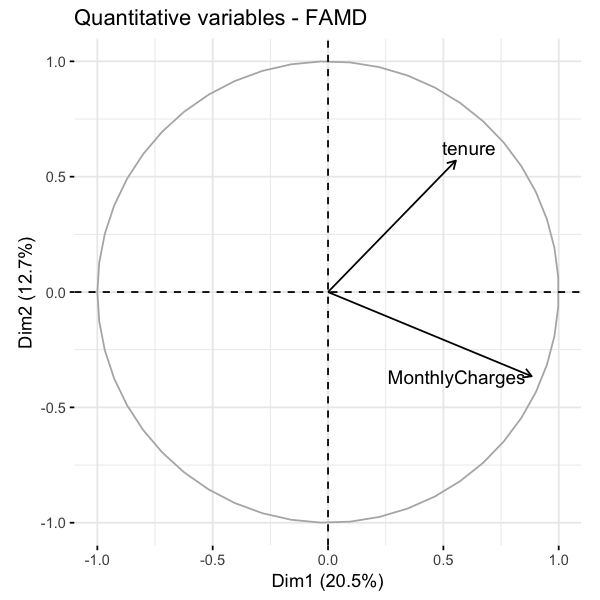

In [4]:
## Import libraries
library(FactoMineR)
library(factoextra)

## PCA
res.famd <- FAMD(df, 
                 sup.var = 19, 
                 graph = FALSE, 
                 ncp=25)

## Plotting
options(repr.plot.width=5, repr.plot.height=5)

fviz_famd_var(res.famd, 
              "quanti.var", 
              repel = TRUE,
              col.var = "black")

To interpret the correlation circle, whereas positively correlated variables appear in the same quadrant, negatively correlated variables are positioned on opposite sides of the origin. So in this example, we see that `Tenure` and `MonthlyCharges` are negative correlated in some way. This makes some intuitive sense, as customers with high monthly charges may not stay very long with the company.

Finally, as a sidenote, the `PCAmixdata` package can produce the exact same plot from the FAMD results. One of the authors of the package has a fairly detailed tutorial [here](https://cran.r-project.org/web/packages/PCAmixdata/vignettes/PCAmixdata.html).

## Categorical variables

In the squared loading plots show in part 2, we could get some rough ideas as to the relationships between categorical variables. However, we can further visualize the relationships between **levels** of categorical variables in **level maps**. This allows us to get much more fine-grained insights, as for example "Senior Citizen" and "Not Senior Citizen" carry very different meanings, which are lost when lumped together into a single variable.

All three packages used in this series have some implementation for this type of visualization, as you will see in the comparison below.

### Using `FactoMineR`

The FAMD implementation in the `FactoMineR` package somehow does not allow display of the supplementary variable (`Churn` in this case), which is key to interpreting the results. However, as FAMD essentially uses multiple correspondence analysis (MCA) to handle the categorical variables, we can directly perform MCA using `FactoMineR` to visualize relationships between various aspects of customer behaviour and our outcome of interest, customer churn.

I will plot results from both FAMD and MCA for the sake of comparison:

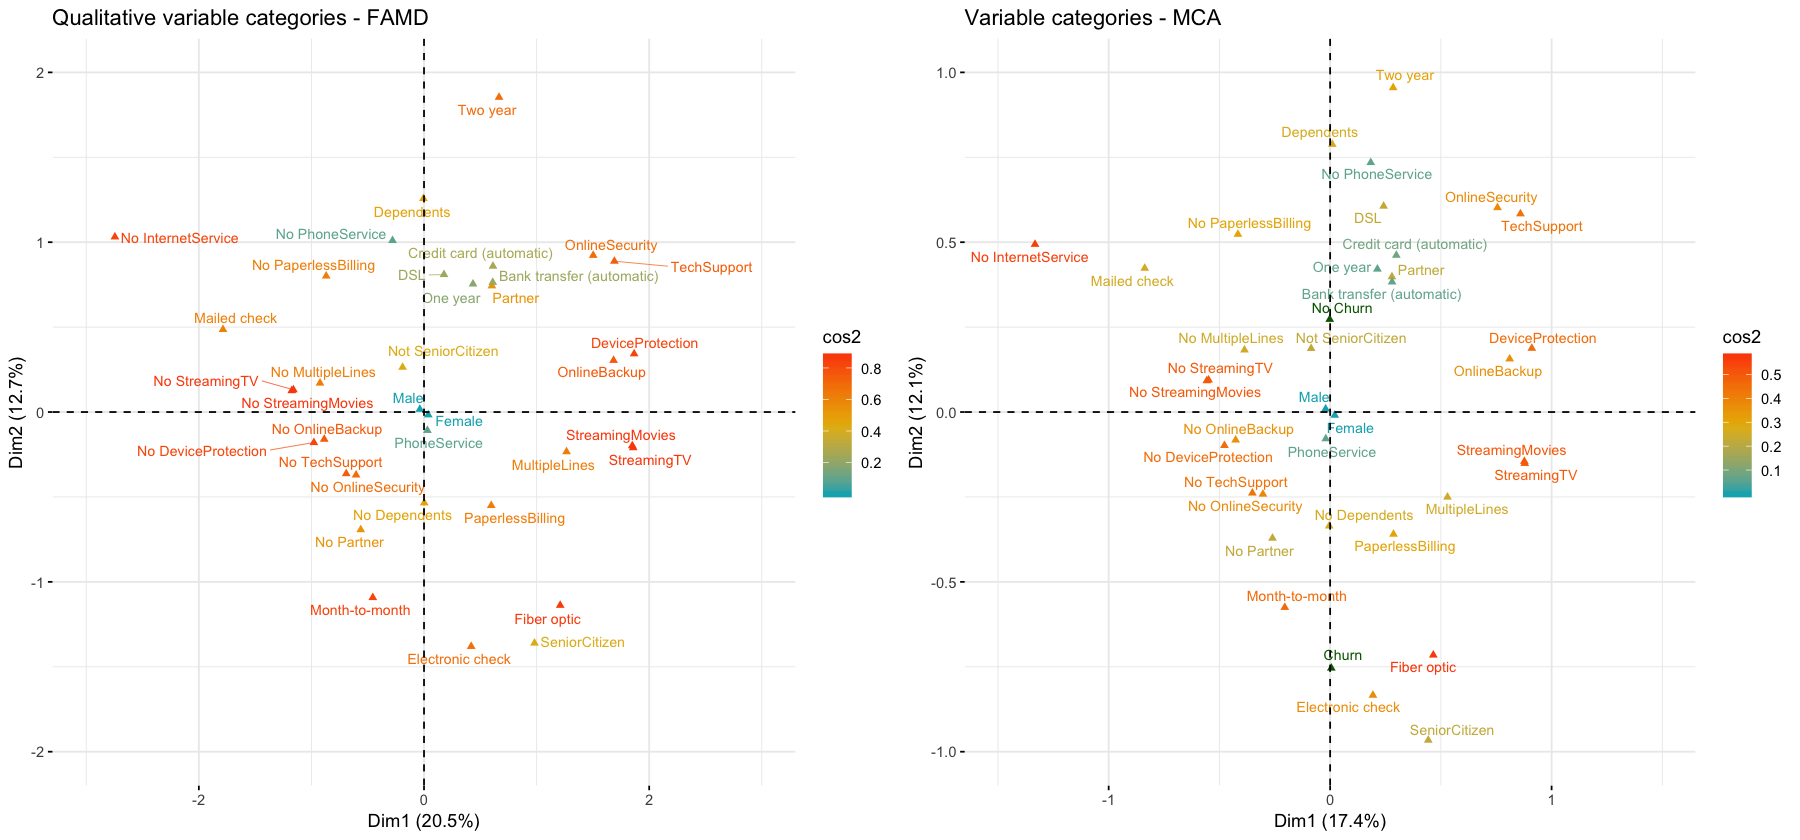

In [14]:
## Import library
library(gridExtra)

## Plot relationship between levels of categorical variables obtained from FAMD
a <- fviz_famd_var(res.famd, "quali.var", col.var = "cos2", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             labelsize = 3,
             repel=TRUE) +
             xlim(-3, 3) + ylim (-2, 2)

## Plot relationship between levels of categorical variables obtained from MCA
res.mca <- MCA(df, quanti.sup=c(5, 18), quali.sup=c(19), graph = FALSE)

b <- fviz_mca_var(res.mca, col.var = "cos2", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             labelsize = 3, 
             repel=TRUE ) +
             xlim(-1.5, 1.5) + ylim (-1, 1)

## Plotting
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(a, b, nrow=1)

We see that the two plots show similar relationships between levels of all categorical variables, but the MCA results allow us to see where "Churn" and "No churn" (in dark green) fall relative to levels of other categorical variables. As **variables that are closer together on the factor map are more closely related**, we can gleam that whereas have a month-to-month plan and paying by electronic cheque are associated with customers who churn, having one-year contract and not being senior citizen are associated with those who do not.

### Using `PCAmixdata`

We can generate the same kind of plot using the results of FAMD with `PCAmixdata`.

Warning message in splitmix(df):
“Columns of class integer are considered as quantitative”

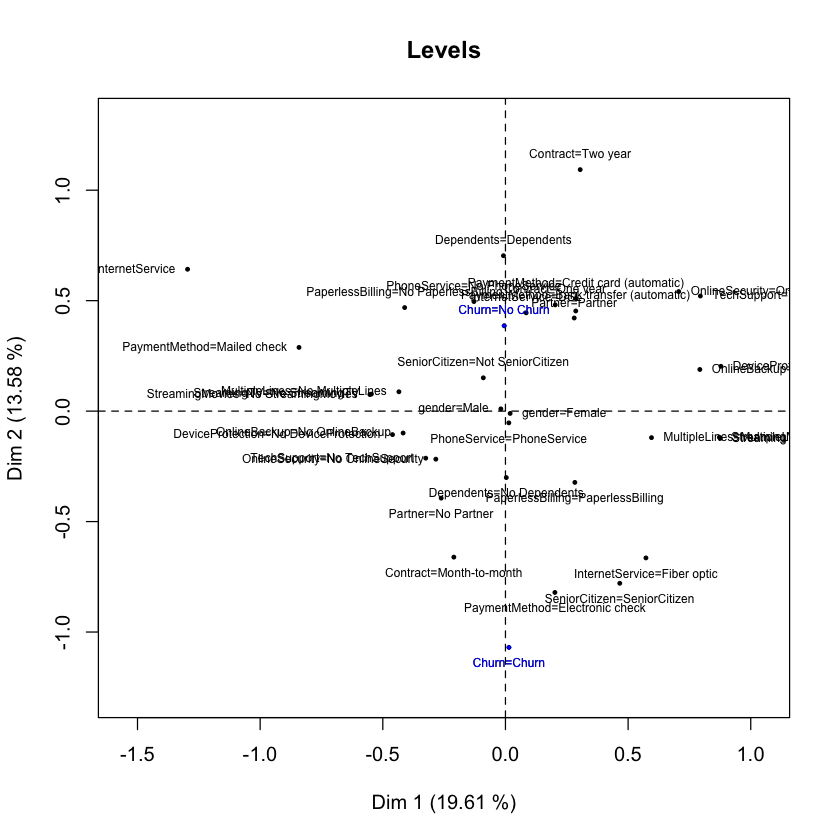

In [24]:
## Import library
library(PCAmixdata)

## Split quantitative and qualitative variables
split <- splitmix(df)

## PCA
res.pcamix <- PCAmix(X.quanti=split$X.quanti,  
                     X.quali=split$X.quali, 
                     rename.level=TRUE, 
                     graph=FALSE, 
                     ndim=25)

## Add "Churn" as a supplementary varible
res.sup <- supvar(res.pcamix,  
                  X.quanti.sup = NULL, 
                  X.quali.sup = df[19], 
                  rename.level=TRUE)

## Plotting
plot(res.sup, 
     choice="levels", 
     main="Levels", 
     cex=0.6)

While we can generate this plot more directly from the FAMD results, but the result is quite a bit less readable and visually appealing than the plots made using `FactoMineR`.

### Using `prince`

If your analysis needs to be in Python, the `prince` is the way to go. As far as I can see, there is not (yet) an option to create this type of factor map direcly from the results of FAMD. However, as mentioned above, we can use MCA to get the same information.

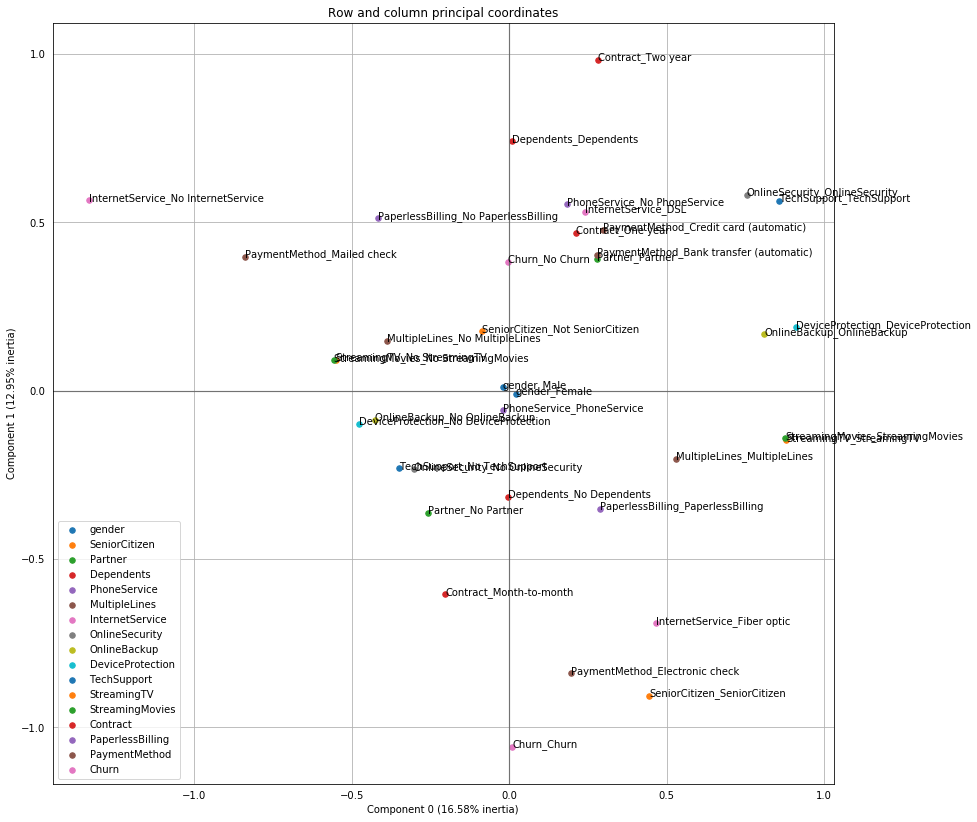

In [23]:
## Import library
import prince

## Instantiate MCA object
mca = prince.MCA(
     n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )

## Fit MCA object to quantative data
mca = mca.fit(df.drop(['tenure', 'MonthlyCharges'], axis=1))

## Generate figure
mca.plot_coordinates(
     df.drop(['tenure', 'MonthlyCharges'], axis=1),
    ax=None,
     figsize=(14, 14),
    show_row_points=False,
    show_row_labels=False,
    show_column_points=True,
     column_points_size=30,
     show_column_labels=True,
     legend_n_cols=1)

Again, we see the same relationships between categorical variables. And again, the figure suffers in comparison with that of `FactoMineR` in terms of aesthetics.

In summary, using the MCA implementation in `FactoMineR` provides the most visually pleasing and informative visual representation of the relationships between categorical variables in a dataset. However, knowing that all three packages deliver very similar results, you have plenty of options depending on your workflow needs.

In the next part of this series, we will bring individual data points into the mix and see what insights we can gain there. 

Til then! :)